# <img src="../../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: supernovae

## Goal

The goal of this notebook is to show how Fink can contribute to supernova science. 

Real-time analysis for follow-up coordination will be better done through the Fink livestreams which processes and makes available the alert data within minutes of reception. Access through this notebook uses the API access which is not real-time based. We aggregate the data into our API and Science Portal database at the end of each observing night. API access can be useful to analyze last night and older alerts. 

In this notebook you will find examples on:
- Early SNe Ia candidates from Fink
- Summary statistics of early SNe Ia filter

## Useful links

- API documentation: https://fink-portal.org/api
- Schema of Fink database: https://fink-portal.org/api/v1/columns
- CDS xmatch service: http://cdsxmatch.u-strasbg.fr/xmatch
- SIMBAD description of classes: http://simbad.u-strasbg.fr/simbad/sim-display?data=otypes

## Environment set up

To run this notebook, you need to import the following libraries (already installed in colab):

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

APIURL = 'https://fink-portal.org'

# Early SNe Ia

**Early supernova candidates is a tag defined and provided by Fink.** 
It requires that the alert has no known transient association (from SIMBAD catalogue), it is relatively new (number of previous detections < 20) and when both a [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173) trained to identify SNe Ia or SNe and a Random Forest (Leoni et al. in prep.) based on [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract) trained to select early supernovae have a probability higher than 50% of this object being a SN.

Currently, we are reporting to the International Astronomical Union Transient Name Server (TNS) our early SN Ia candidates https://www.wis-tns.org

We will query the **latests alerts wich are classified as Early SN candidates**. In Fink we process alerts, an object can contain several alerts (linked to observations).

In [2]:
r = requests.post(
  '{}/api/v1/latests'.format(APIURL),
  json={
    'class': 'Early SN Ia candidate',
    'n': '10', # number of alerts (200 max)
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

You will get a pandas DataFrame with the column schema from https://fink-portal.org/api/v1/columns. To check the columns:

In [3]:
pdf.keys()

Index(['d:cdsxmatch', 'd:mulens', 'd:rf_kn_vs_nonkn', 'd:rf_snia_vs_nonia',
       'd:roid', 'd:snn_sn_vs_all', 'd:snn_snia_vs_nonia', 'i:candid',
       'i:chipsf', 'i:classtar', 'i:dec', 'i:diffmaglim', 'i:distnr',
       'i:distpsnr1', 'i:drb', 'i:fid', 'i:field', 'i:isdiffpos', 'i:jd',
       'i:jdendhist', 'i:jdstarthist', 'i:maggaia', 'i:magnr', 'i:magpsf',
       'i:magzpsci', 'i:ndethist', 'i:neargaia', 'i:nid', 'i:nmtchps',
       'i:objectId', 'i:publisher', 'i:ra', 'i:rb', 'i:rcid', 'i:sgscore1',
       'i:sigmagnr', 'i:sigmapsf', 'i:ssdistnr', 'i:ssmagnr', 'i:ssnamenr',
       'i:tooflag', 'i:xpos', 'i:ypos', 'd:tracklet', 'v:classification',
       'v:lastdate', 'v:constellation'],
      dtype='object')

###  <font color='blue'>Tip #1:</font> reproducibility
Thsi query return the **latests** alerts on this class. You may want to fix a date range to ensure reproducibility of results

In [4]:
r = requests.post(
  '{}/api/v1/latests'.format(APIURL),
  json={
    'class': 'Early SN Ia candidate',
    'n': '10', # number of alerts (200 max)
    'startdate': '2021-04-01', # use a start date
    'stopdate': '2021-04-13', # use a stop date
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

###  <font color='blue'>Tip #2:</font> faster querying 
This data frame contains many columns that you may not need. To make this query run faster we can easily set up a query with a limited number of columns!

In [5]:
r = requests.post(
  '{}/api/v1/latests'.format(APIURL),
  json={
    'class': 'Early SN Ia candidate',
    'n': '10', # number of alerts (200 max)
    'startdate': '2021-04-01', # use a start date
    'stopdate': '2021-04-13', # use a stop date
    'columns': 'i:objectId,d:cdsxmatch,d:rf_snia_vs_nonia,d:snn_snia_vs_nonia,d:snn_sn_vs_all',
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

In [6]:
pdf

,d:cdsxmatch,d:rf_snia_vs_nonia,d:snn_sn_vs_all,d:snn_snia_vs_nonia,i:objectId
0,Unknown,0.957,0.787708,0.880269,ZTF21aarmkuj
1,Unknown,0.751,0.604498,0.736482,ZTF21aatitlf
2,Unknown,0.941,0.984186,0.872538,ZTF21aaqxiaj
3,Unknown,0.668,0.909120,0.882660,ZTF21aaquhqr
4,Unknown,0.657,0.909349,0.883286,ZTF21aaquhqr
5,Unknown,0.922,0.874443,0.706066,ZTF21aassamj
6,Unknown,0.622,0.751971,0.692514,ZTF21aarskup
7,Unknown,0.823,0.759206,0.671824,ZTF21aaswvyc
8,Unknown,0.698,0.835022,0.818026,ZTF21aarskup
9,Unknown,0.973,0.677686,0.787034,ZTF21aassamj


### Get photometry

The `latests` service will give you latests alerts associated to a particular class, but you will not have the full photometry of each object and its thumbnails. For this, you can query the `objects` service using a previously returned `objectId`

You can query one by one object or do a request in a loop to get many

In [7]:
cand_objId = pdf['i:objectId'][0]
print(f"Get photometry of {cand_objId}")

Get photometry of ZTF21aarmkuj


In [8]:
# Get alerts associated with an specific object ID
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': cand_objId, # this is the object ID of this candidate
    'withupperlim': 'True', # retrieve also upper limit measurements, and bad quality measurements
  }
)

# Format output in a DataFrame
pdf_phot_single_obj = pd.read_json(r.content)

In [9]:
pdf_phot_single_obj.keys()

Index(['b:cutoutDifference_stampData', 'b:cutoutScience_stampData',
       'b:cutoutTemplate_stampData', 'd:cdsxmatch', 'd:mulens', 'd:nalerthist',
       'd:rf_kn_vs_nonkn', 'd:rf_snia_vs_nonia', 'd:roid', 'd:snn_sn_vs_all',
       ...
       'v:classification', 'v:g-r', 'v:rate(g-r)', 'v:dg', 'v:rate(dg)',
       'v:dr', 'v:rate(dr)', 'v:lastdate', 'v:constellation', 'd:tag'],
      dtype='object', length=130)

### Plot light-curve for visualization

See the example on http://fink-portal.org/api to plot full lightcurve with layout template.  We implement here an useful function for plotting light-curves in this notebook.

In [10]:
def plot_lc(pdf):
    """ Plot photometry contains in an alert
    
    Parameters
    ----------
    pdf: pandas DataFrame
        Pandas DataFrame with single alert row
    """
    fig = plt.figure(figsize=(15, 6))

    # Colors to plot
    colordic = {1: 'C0', 2: 'C1'}

    # Labels of ZTF filters
    filtdic = {1: 'g', 2: 'r'}

    for filt in np.unique(pdf['i:fid']):
        # select data from one filter at a time
        maskFilt = pdf['i:fid'] == filt

        # The column `d:tag` is used to check data type
        maskValid = pdf['d:tag'] == 'valid'
        plt.errorbar(
            pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskValid & maskFilt]['i:magpsf'],
            pdf[maskValid & maskFilt]['i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt], label=filtdic[filt]
        )

        maskUpper = pdf['d:tag'] == 'upperlim'
        plt.plot(
            pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskUpper & maskFilt]['i:diffmaglim'],
            ls='', marker='v', color=colordic[filt], markerfacecolor='none'
        )

        maskBadquality = pdf['d:tag'] == 'badquality'
        plt.errorbar(
            pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskBadquality & maskFilt]['i:magpsf'],
            pdf[maskBadquality & maskFilt]['i:sigmapsf'],
            ls='', marker='^', color=colordic[filt]
        )

    plt.gca().invert_yaxis()
    plt.legend()
    plt.title(pdf['i:objectId'][0])
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')
    plt.show()
    msg = """
    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    """
    print(msg)

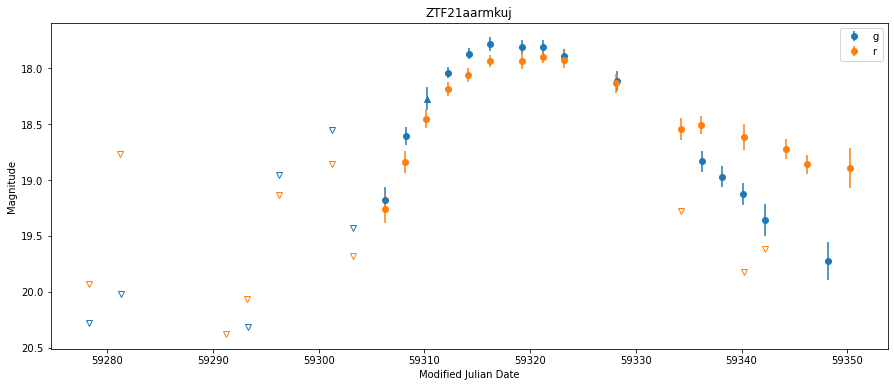


    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    


In [11]:
plot_lc(pdf_phot_single_obj)

### Was this object spectroscopically classified?

We report SN Ia candidates, however to confirm they are SNe Ia we need a realiable classification mechanism. 

We can now query International Astronomical Union Transient Name Server (TNS) for spectroscopic classifications of transients. Fink contains now a class '(TNS) SN Ia' for all spectrsocopically classified SNe Ia 

In [12]:
r = requests.post(
  '{}/api/v1/latests'.format(APIURL),
  json={
    'class': '(TNS) SN Ia',
    'n': '200', # number of alerts (200 max)
    'startdate': '2021-04-01', # use a start date
    'stopdate': '2021-04-15', # use a stop date
    'columns': 'i:objectId,d:cdsxmatch,d:rf_snia_vs_nonia,d:snn_snia_vs_nonia,d:snn_sn_vs_all',
  }
)

# Format output in a DataFrame
pdf_tns = pd.read_json(r.content)

In [13]:
# fetch objIds of spectroscopic SNe Ia
tns_objId = pdf_tns['i:objectId'].values

In [14]:
cand_objId

'ZTF21aarmkuj'

In [15]:
[s for s in tns_objId if cand_objId in s]

[]

**This object was later classified spectroscopically as a type SN!**

# FIX ME!

# Summary statistics of early SNe Ia filter
Until now, we have only analysed either latest alerts or an specific object. It may be useful to get some summary statistics of this filter in Fink. To do so, we can use another request in the API. 

In [16]:
# get stats for all the year 2021
r = requests.post(
  'https://fink-portal.org/api/v1/statistics',
  json={
    'date': '2021',
    'output-format': 'json'
  }
)
# Format output in a DataFrame
pdf_stats = pd.read_json(r.content)

This dataframe is organized by observing night for this year. Where 'key:key' is the ztf date and 

In [17]:
pdf_stats.keys().to_list()

['basic:exposures',
 'basic:fields',
 'basic:n_g',
 'basic:n_r',
 'basic:raw',
 'basic:sci',
 'class:**',
 'class:AGB*',
 'class:AGN',
 'class:AGN_Candidate',
 'class:Ae*',
 'class:Ambiguous',
 'class:Assoc*',
 'class:BClG',
 'class:BLLac',
 'class:BLLac_Candidate',
 'class:BYDra',
 'class:Be*',
 'class:Blazar',
 'class:Blazar_Candidate',
 'class:Blue',
 'class:BlueCompG',
 'class:BlueSG*',
 'class:BlueStraggler',
 'class:Bubble',
 'class:C*',
 'class:Candidate_AGB*',
 'class:Candidate_Ae*',
 'class:Candidate_BSG*',
 'class:Candidate_Be*',
 'class:Candidate_C*',
 'class:Candidate_CV*',
 'class:Candidate_Cepheid',
 'class:Candidate_EB*',
 'class:Candidate_HB*',
 'class:Candidate_HMXB',
 'class:Candidate_Hsd',
 'class:Candidate_LMXB',
 'class:Candidate_LP*',
 'class:Candidate_Lens',
 'class:Candidate_LensSystem',
 'class:Candidate_Mi*',
 'class:Candidate_Nova',
 'class:Candidate_RGB*',
 'class:Candidate_RRLyr',
 'class:Candidate_RSG*',
 'class:Candidate_S*',
 'class:Candidate_SG*',
 'cla

To get the stats for the whole year of SNe Ia candidates

In [18]:
n_alerts_earlySNeIa = pdf_stats['class:Early SN Ia candidate'].sum()

In [19]:
print(f"Numer of alerts classified as Early SNe Ia {int(n_alerts_earlySNeIa)}")

Numer of alerts classified as Early SNe Ia 3728


Text(0.5, 0, 'Number of alerts')

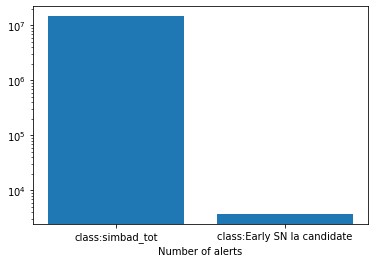

In [20]:
cols = ['class:simbad_tot','class:Early SN Ia candidate']
plt.bar(cols, pdf_stats[cols].sum())
plt.yscale('log')
plt.xlabel('Number of alerts')